In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, explained_variance_score
from numpy.linalg import inv, solve
import matplotlib.pyplot as plt
from utils_plot import *

In [2]:
def fourier_basis(theta, num_harmonics=3):
    """
    Generates a Fourier basis matrix using sine and cosine components
    """
    basis = np.zeros((2*num_harmonics,len(theta)))
    for i in range(num_harmonics):
        basis[2*i,:] = np.cos(2*(i+1)*np.pi*(theta))
        basis[2*i+1,:] = np.sin(2*(i+1)*np.pi*(theta))

    return basis
def fourier_fit(data, num_harmonics=3):
    # Generate Fourier basis for fitting (for original thetas)
    fourier_matrix = fourier_basis(thetas, num_harmonics)  # Shape: (2*num_harmonics+1, len(thetas))

    # Solve for all TFs using least squares
    params, _, _, _ = np.linalg.lstsq(fourier_matrix.T, data.T, rcond=None)  # Shape: (2*num_harmonics+1, TFs)

    # Generate Fourier basis for smooth theta values
    fourier_matrix_smooth = fourier_basis(theta_smooth, num_harmonics)  # Shape: (2*num_harmonics+1, 100)

    # Compute A_smooth for all TFs
    data_smooth = params.T @ fourier_matrix_smooth  # Shape: (TFs, 100)
    
    return data_smooth

In [3]:
# 1. Data Normalization

def filter_genes(E_raw, N_raw, ampl_threshold=0.5):
    targetnames_N = N_raw.index
    targetnames_E = adata.var_names
    targetnames = targetnames_E.intersection(targetnames_N)
    E_raw = E_raw[[targetnames_E.get_loc(name) for name in list(targetnames)], :]
    
    # Calculates amplitude over noise of rates around the cell cycle
    E_smooth = fourier_fit(E_raw) #Fit E = f(theta)
    ampl = (E_smooth.max(axis=1)-E_smooth.min(axis=1))/2
    ind = ampl > ampl_threshold
    E_raw = E_raw[ind,:]
    targetnames = targetnames[ind]
    
    N_raw = N_raw.loc[targetnames].to_numpy()

    return E_raw, N_raw, targetnames

def normalize(E, N):
    """
    Double-center the expression matrix E.
    Subtract row means and column means and add the overall global mean.
    This yields an E' with row and column means zero.
    Center the site-count matrix N by subtracting the mean for each motif (i.e., each column).
    """
    E_norm = E - np.mean(E, axis=1, keepdims=True) - np.mean(E, axis=0, keepdims=True) + np.mean(E)
    N_norm = N - np.mean(N, axis=0, keepdims=True)

    return E_norm, N_norm

In [4]:
# 2. Ridge Regression Solver

def ridge_regression_solution(N_norm, E_norm, lam):
    """
    Solves for A in the ridge regression model:
      (N_norm.T @ N_norm + lam I) * A = N_norm.T @ E_norm
    Returns A, with shape (n_motifs, n_cells).
    """
    M = N_norm.T @ N_norm  # shape: (n_motifs, n_motifs)
    I = np.eye(M.shape[0])
    A = solve(M + lam * I, N_norm.T @ E_norm)
    return A

In [5]:
# 3. Cross-Validation to Optimize Lambda
def cross_val_lambda(N_norm, E_norm, lam_candidates, n_splits=5, random_state=42):
    """
    Perform KFold cross validation over promoters (rows) to select the best lambda.
    
    Parameters:
      N_norm: np.array, shape (n_promoters, n_motifs), normalized site-count matrix.
      E_norm: np.array, shape (n_promoters, n_cells), normalized expression matrix.
      lam_candidates: iterable of candidate lambda values.
      n_splits: int, number of folds (default 5).
      random_state: int, random seed for reproducibility.
      
    Returns:
      best_lam: the lambda value that minimizes the average MSE across folds.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    EVs_train = []
    EVs_test = []
    MSEs_train = []
    MSEs_test = []
    
    # Loop over folds.
    for train_idx, test_idx in kf.split(N_norm):
        N_train = N_norm[train_idx, :]
        E_train = E_norm[train_idx, :]
        N_test = N_norm[test_idx, :]
        E_test = E_norm[test_idx, :]
        
        EV_fold_train = []
        EV_fold_test = []
        MSE_fold_train = []
        MSE_fold_test = []
        
        # For each candidate lambda, compute the model predictions.
        for lam in lam_candidates:
            # Fit the ridge regression model on training set:
            A_hat = ridge_regression_solution(N_train, E_train, lam)
            # Predictions for training and test sets:
            R_train = N_train @ A_hat
            R_test = N_test @ A_hat
            
            # Compute explained variance and MSE:
            EV_train = explained_variance_score(E_train, R_train)
            EV_test = explained_variance_score(E_test, R_test)
            mse_train = mean_squared_error(E_train, R_train)
            mse_test = mean_squared_error(E_test, R_test)
            
            EV_fold_train.append(EV_train)
            EV_fold_test.append(EV_test)
            MSE_fold_train.append(mse_train)
            MSE_fold_test.append(mse_test)
        
        EVs_train.append(EV_fold_train)
        EVs_test.append(EV_fold_test)
        MSEs_train.append(MSE_fold_train)
        MSEs_test.append(MSE_fold_test)
        print("Fold done")
    
    # Convert to arrays of shape (n_splits, len(lam_candidates))
    EVs_train = np.array(EVs_train)
    EVs_test = np.array(EVs_test)
    MSEs_train = np.array(MSEs_train)
    MSEs_test = np.array(MSEs_test)
    
    # Average across folds:
    avg_EVs_test = np.mean(EVs_test, axis=0)
    avg_MSEs_test = np.mean(MSEs_test, axis=0)
    
    # Here, we choose the lambda that gives the highest average EV (you could also choose by lowest MSE).
    best_index = np.argmax(avg_EVs_test)
    best_lam = lam_candidates[best_index]
    best_EV = avg_EVs_test[best_index]
    best_MSE = avg_MSEs_test[best_index]
    
    # Plot the performance metrics vs lambda:
    plt.figure(figsize=(12, 5))
    
    # Subplot for Explained Variance:
    plt.subplot(1, 2, 1)
    for i in range(n_splits):
        plt.plot(lam_candidates, EVs_train[i], linestyle="--", color="green", alpha=0.6, label="Train" if i==0 else "")
        plt.plot(lam_candidates, EVs_test[i], linestyle="--", color="orange", alpha=0.6, label="Test" if i==0 else "")
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Explained Variance (EV)")
    plt.title("Explained Variance vs Lambda")
    plt.legend()
    plt.grid(True)
    
    # Subplot for Mean Squared Error:
    plt.subplot(1, 2, 2)
    for i in range(n_splits):
        plt.plot(lam_candidates, MSEs_train[i], linestyle="--", color="blue", alpha=0.6, label="Train" if i==0 else "")
        plt.plot(lam_candidates, MSEs_test[i], linestyle="--", color="magenta", alpha=0.6, label="Test" if i==0 else "")
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("MSE vs Lambda")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    return best_lam, best_EV, best_MSE

In [6]:
#4. Final perf evaluation on best lambda
def train_best_model(N_norm, E_norm, best_lam, n_splits=5, random_state=42):
    # Define the number of folds
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    print("Train for lambda =", best_lam)

    # Perform K-Fold cross-validation
    for train_idx, test_idx in kf.split(N_norm):
        N_train = N_norm[train_idx, :]
        E_train = E_norm[train_idx, :]
        N_test = N_norm[test_idx, :]
        E_test = E_norm[test_idx, :]

        # Solve ridge regression for current lambda on the training set.
        A_hat = ridge_regression_solution(N_train, E_train, best_lam)
        R_train = N_train @ A_hat
        R_test = N_test @ A_hat
        # Predict on the test set.
        EV_train = explained_variance_score(E_train, R_train)
        EV_test = explained_variance_score(E_test, R_test)
        mse_train = mean_squared_error(E_train, R_train)
        mse_test = mean_squared_error(E_test, R_test)
        print("EV_train :", round(EV_train*100,2), "%", "MSE_train :", round(mse_train,2))
        print("EV_test :", round(EV_test*100,2), "%", "MSE_test :", round(mse_test,2), "\n")
        
    return A_hat, train_idx, test_idx, E_test, R_test, E_train, R_train

/shared/home/suttyg/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Kept genes : 783
Fold done
Fold done
Fold done
Fold done
Fold done


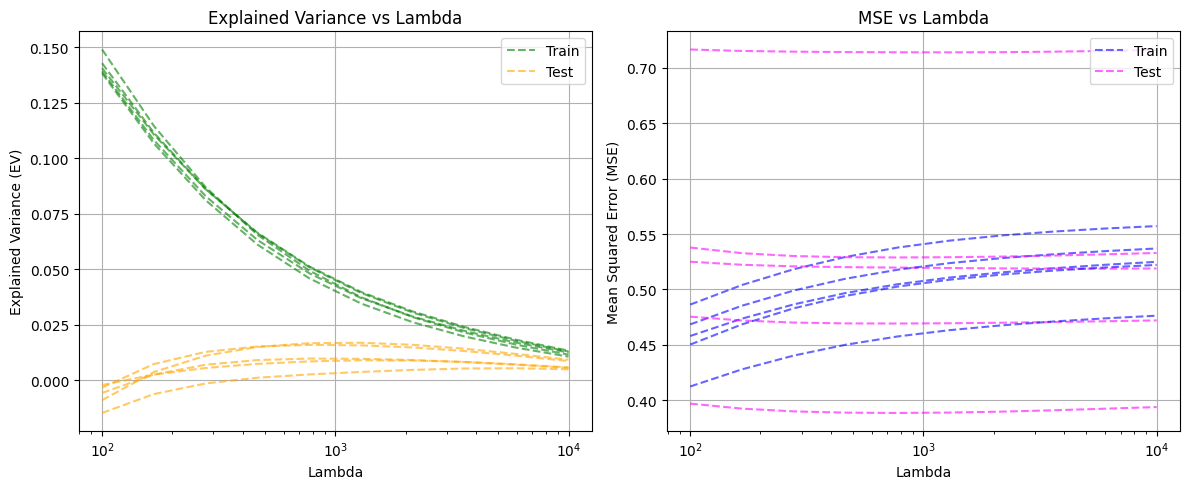

Best lambda: 1291.549665014884
Best EV: 0.010991850114612133
Best MSE: 0.524140979095926


In [7]:
filedeepcycle = "/shared/space2/molina/Data/mESCs_2iLIF/SRR13790993/deepcycle/deepcycle.h5ad"
fileBSM = 'Data/data_binding_site_matrix.txt'
process = ["transcription", "\u03B1"]
theta_smooth = np.linspace(0, 1, 100)

N_raw = pd.read_csv(fileBSM, sep="\t",index_col=0)
adata = sc.read_h5ad(filedeepcycle)
adata.var_names_make_unique()
thetas = adata.obs['cell_cycle_theta']
E_raw = adata.layers['Mu'].T

#Select common genes between E and N
E_raw, N_raw, targetnames = filter_genes(E_raw, N_raw, ampl_threshold=0.5)

# Normalize the data
E_norm, N_norm = normalize(E_raw, N_raw)
print("Kept genes :", E_norm.shape[0])

# Define candidate lambda values (you may adjust this range as needed)
lam_candidates = np.logspace(2, 4, 10)  # from 0.001 to 10
best_lam, best_EV, best_MSE = cross_val_lambda(N_norm, E_norm, lam_candidates, random_state=40)
print("Best lambda:", best_lam)
print("Best EV:", best_EV)
print("Best MSE:", best_MSE)

In [8]:
A_hat, train_idx, test_idx, E_test, R_test, E_train, R_train = train_best_model(N_norm, E_norm, best_lam, random_state=40)

Train for lambda = 1291.549665014884
EV_train : 3.45 % MSE_train : 0.54
EV_test : 1.69 % MSE_test : 0.39 

EV_train : 3.97 % MSE_train : 0.51
EV_test : 0.37 % MSE_test : 0.52 

EV_train : 3.7 % MSE_train : 0.52
EV_test : 0.97 % MSE_test : 0.47 

EV_train : 3.93 % MSE_train : 0.46
EV_test : 0.9 % MSE_test : 0.71 

EV_train : 3.74 % MSE_train : 0.51
EV_test : 1.57 % MSE_test : 0.53 



In [9]:
# Calculates amplitude over noise of rates around the cell cycle
E_test, R_test, E_train, R_train = fourier_fit(E_test), fourier_fit(R_test), fourier_fit(E_train), fourier_fit(R_train)

In [10]:
print(np.where(targetnames[train_idx] =='Nusap1'))
print(np.where(targetnames[test_idx] =='Nusap1'))

(array([365]),)
(array([], dtype=int64),)


Train


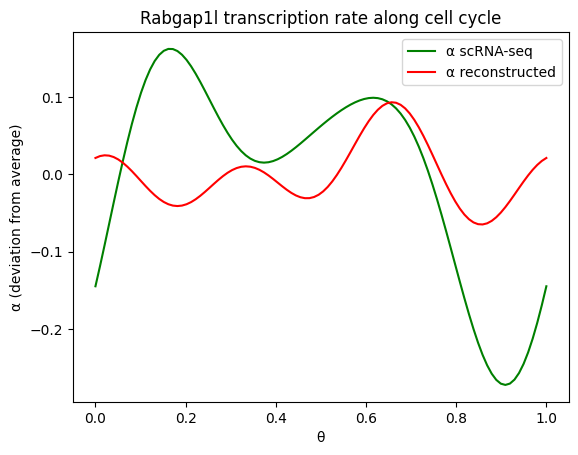

Test


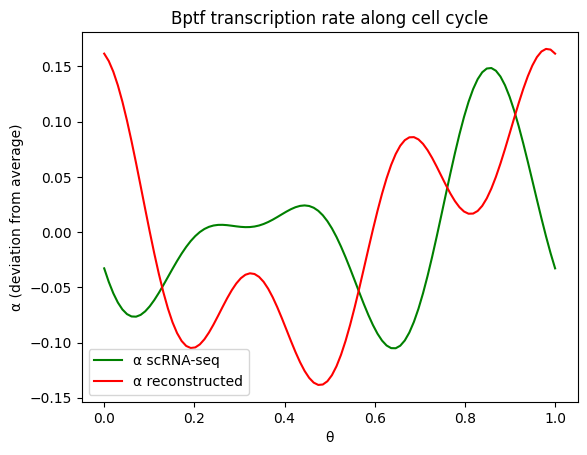

In [11]:
n = 20
print("Train")
plot_rate_comparison(targetnames[train_idx], E_train, R_train, process, theta_smooth, target_nb=n)
print("Test")
plot_rate_comparison(targetnames[test_idx], E_test, R_test, process, theta_smooth, target_nb=n)

In [12]:
#### APPENDIX

In [13]:
# Calculate z-values error bars for activities

def compute_covariance_matrix(N_norm, lam):
    """
    Computes the inverse term common to all cells: inv(N_norm.T @ N_norm + lam I).
    This will later be scaled by sigma^2 per cell.
    """
    M = N_norm.T @ N_norm
    I = np.eye(M.shape[0])
    inv_term = inv(M + lam * I)
    return inv_term

def compute_residual_variance(E_norm, N_norm, A):
    """
    Computes the residual variance (sigma^2) per cell.
    For each cell (each column in E_norm), calculate the mean squared error
    between the observed E_norm and the predicted values from N_norm @ A.
    """
    residuals = E_norm - (N_norm @ A)
    sigma2 = np.mean(residuals**2, axis=0)  # one value per cell
    return sigma2

def get_z_values(E_norm, N_norm, A_hat, best_lam):
    # Compute residual variance per cell
    sigma2 = compute_residual_variance(E_norm, N_norm, A_hat)
    
    # Compute the inverse term (common for all cells) for covariance estimation
    inv_term = compute_covariance_matrix(N_norm, best_lam)
    
    # For each cell, compute the standard errors for each motif activity.
    n_motifs, n_cells = A_hat.shape
    error_bars = np.zeros((n_motifs, n_cells))
    for j in range(n_cells):
        # Standard error for each motif m in cell j: sqrt(diag(inv_term) * sigma2[j])
        error_bars[:, j] = np.sqrt(np.diag(inv_term) * sigma2[j])
    
    # Compute z-values for each motif and cell
    z_values = A_hat / error_bars
    return z_values

#z_values = get_z_values(E_norm, N_norm, A_hat, best_lam)